In [105]:
import pickle
import random
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import plot_estimates, plot_rmse, plot_traj, rmse, rmse_avg, rmse_network
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
# Simulation parameters
RUNS = 1
NETWORK_FILE = "./networks/network_15_6.pkl"
OUTPUT_DIR = "./simulations/04_random_init/"
FID = "resetci"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 1000
# q = 5e-4  # Process noise intensity
# r = 20  # Observation noise std
q = 5e-4  # Process noise intensity
r = 25  # Observation noise std
TRAJ_MODEL = CAModel(q, r)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 20  # RWM process noise scaling constant
c_cvm = 10
expf_rwm = 0.9  # Exponential forgetting param
expf_cvm = 0.95
reset_thresh = 10  # Filter reset threshold (Euclidean distance from centroid)

n_rwm = 2
n_cvm = 4
n_cam = 9

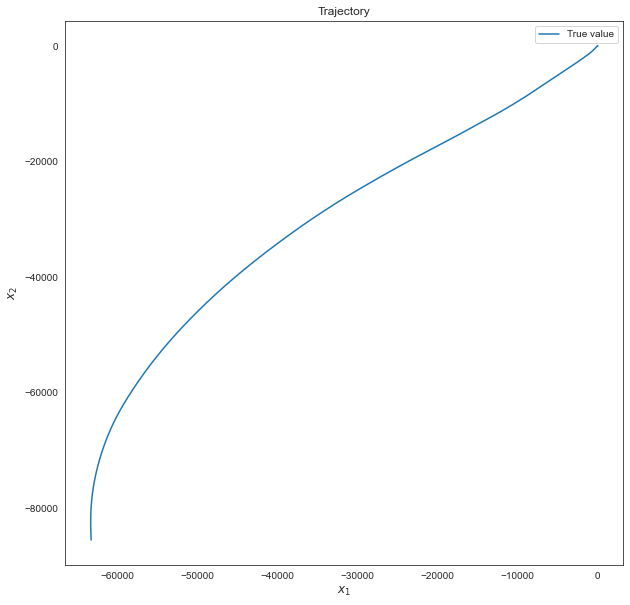

In [108]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

plot_traj(traj)

In [109]:
# Run simulations
rmse_camnc = np.zeros((ndat, 2))
rmse_rwm = np.zeros((ndat, 2))
rmse_cvm = np.zeros((ndat, 2))
rmse_cam = np.zeros((ndat, 2))


random_n = random.randint(0, RUNS - 1)
for i in range(RUNS):
    # Random network initialization
    #     rwms = [
    #         KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf_rwm) for i in range(n_rwm)
    #     ]
    #     cvms = [
    #         KalmanFilter(CVModel(c_cvm * q, r), lambda_expf=expf_cvm) for i in range(n_cvm)
    #     ]
    #     cams = [KalmanFilter(CAModel(q, r)) for i in range(n_cam)]
    #     kfs = rwms + cvms + cams
    #     random.shuffle(kfs)

    #     Fixed network initialization
    kfs = [
        KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf_rwm),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CVModel(c_cvm * q, r), lambda_expf=expf_cvm),
        KalmanFilter(CVModel(c_cvm * q, r), lambda_expf=expf_cvm),
        KalmanFilter(CVModel(c_cvm * q, r), lambda_expf=expf_cvm),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CVModel(c_cvm * q, r), lambda_expf=expf_cvm),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf_rwm),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
    ]
    rwms = [kf for kf in kfs if isinstance(kf.model, RWModel)]
    cvms = [kf for kf in kfs if isinstance(kf.model, CVModel)]
    cams = [kf for kf in kfs if isinstance(kf.model, CAModel)]

    # Single CAM node for comparison
    camnc = KalmanFilter(CAModel(q, r))

    # Load network topology file
    kfn = None
    with open(NETWORK_FILE, "rb") as f:
        kfn = pickle.load(f)
    kfn.assign(init=kfs)
    kfn.generate_txt_labels()
    #     kfn = KFNet(nodes=15, avg_deg=6, init=kfs)
    #     kfn.generate_txt_labels()

    # Add observation noise for each node
    traj.simulate(ndat, INIT_STATE)
    R = kfn.observation_covs()
    traj.add_obs_noise(R)

    # Run estimation
    for yt in traj.observations:
        kfn.time_step(
            yt,
            predict=True,
            update=True,
            adapt=True,
            combine=True,
            reset_strategy="ci",
            reset_thresh=reset_thresh,
            c=0.95,
        )

        camnc.predict()
        camnc.update(yt[4], log=True)

    # Save results
    rmse_camnc += rmse(traj.states[:, :2], camnc.history[:, :2], ndat)

    rmse_rwm += rmse_avg(rwms, traj, ndat, 2)
    rmse_cvm += rmse_avg(cvms, traj, ndat, 2)
    rmse_cam += rmse_avg(cams, traj, ndat, 2)

    if random_n == i:
        # Save state estimates of a random run
        for ms, fn in zip((rwms, cvms, cams), ("rwm", "cvm", "cam")):
            for i, m in enumerate(ms):
                df = m.to_dataframe(traj)
#                 df.to_csv(f"{OUTPUT_DIR}{fn}{i+1}_{FID}.csv", index_label="t")

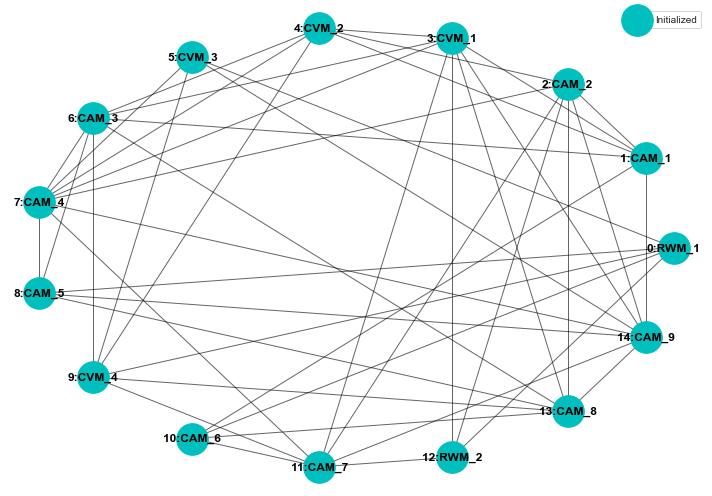

In [110]:
kfn.draw_network()

In [111]:
# Average the results
rmse_camnc /= RUNS

rmse_rwm /= RUNS
rmse_cvm /= RUNS
rmse_cam /= RUNS

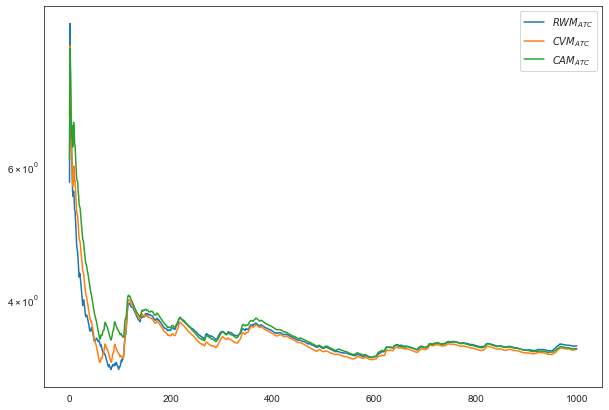

In [112]:
plt.figure(figsize=(10, 7))
# plt.plot(rmse_camnc[:, 0], label="$CAM_{single}$")

plt.plot(rmse_rwm[:, 0], label="$RWM_{ATC}$")
plt.plot(rmse_cvm[:, 0], label="$CVM_{ATC}$")
plt.plot(rmse_cam[:, 0], label="$CAM_{ATC}$")

plt.yscale("log", base=10)
plt.legend()
plt.show()

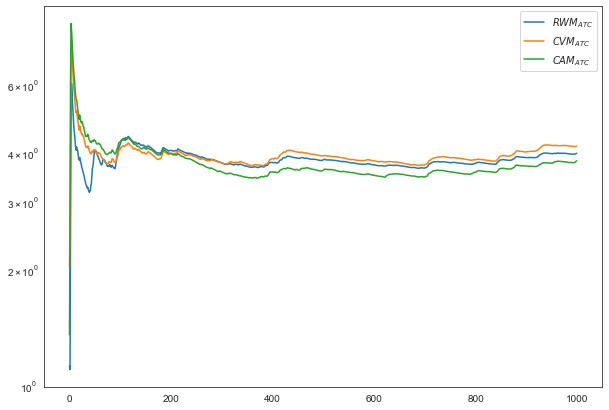

In [113]:
plt.figure(figsize=(10, 7))
# plt.plot(rmse_camnc[:, 0], label="$CAM_{single}$")

plt.plot(rmse_rwm[:, 1], label="$RWM_{ATC}$")
plt.plot(rmse_cvm[:, 1], label="$CVM_{ATC}$")
plt.plot(rmse_cam[:, 1], label="$CAM_{ATC}$")

plt.yscale("log", base=10)
plt.legend()
plt.show()

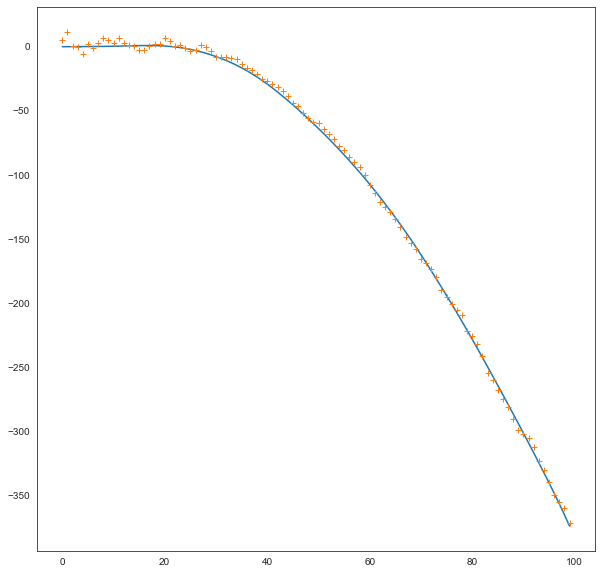

In [114]:
plt.figure(figsize=(10, 10))
plt.plot(traj.X[:100, 0])
plt.plot(rwms[0].history[:100, 0], "+")

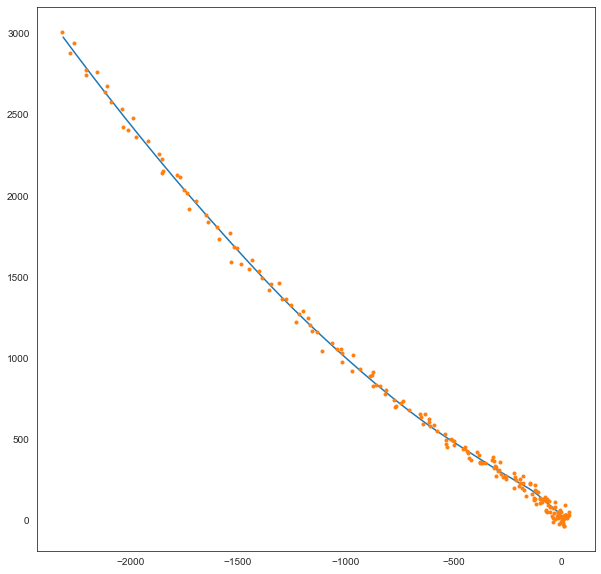

In [115]:
plt.figure(figsize=(10, 10))
plt.plot(traj.X[:200, 0], traj.X[:200, 1])
plt.plot(traj.Y[:200, 0, 0], traj.Y[:200, 0, 1], ".")

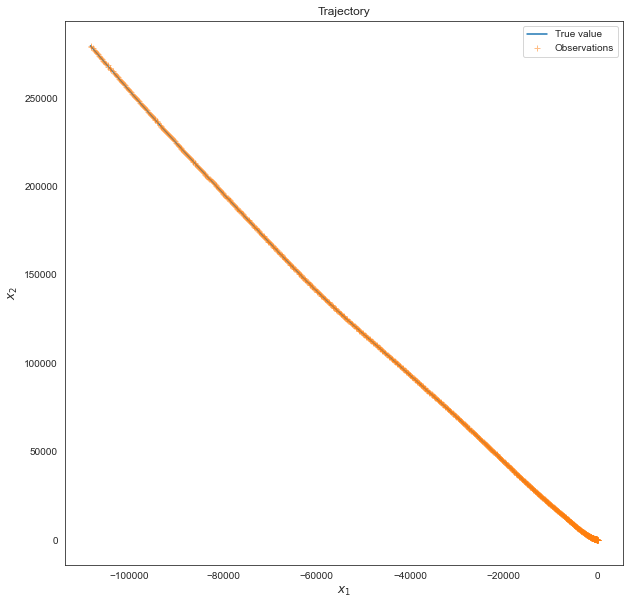

In [116]:
plot_traj(traj, obs=8)

In [117]:
print("RWM resets:")
for rx in rwms:
    print(len(rx._reset_log))

print("CVM resets:")
for cx in cvms:
    print(len(cx._reset_log))

print("CAM resets:")
for cx in cams:
    print(len(cx._reset_log))

RWM resets:
908
906
CVM resets:
0
0
0
0
CAM resets:
3
0
0
0
0
4
0
0
0


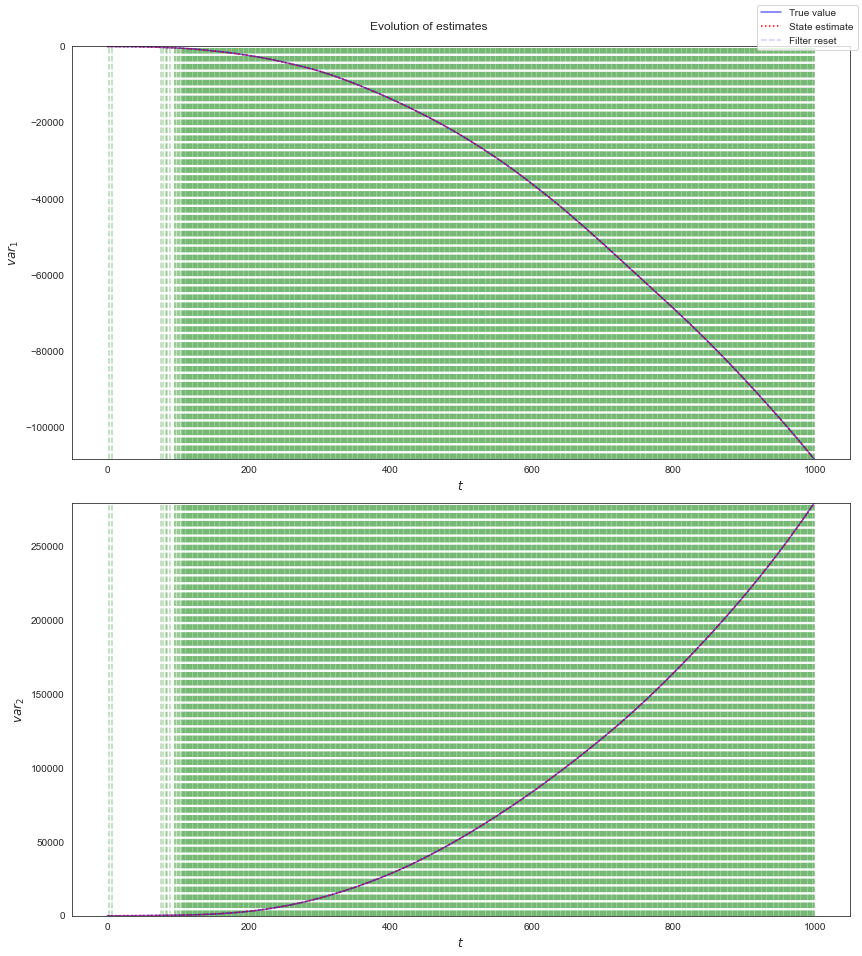

In [118]:
plot_estimates(rwms[0], traj)

In [119]:
rmse_data = np.hstack((rmse_rwm, rmse_cvm, rmse_cam))
cols = []
for m in ("rwm", "cvm", "cam"):
    for x in ("x1", "x2"):
        cols.append(f"{m}_{x}")

df = pd.DataFrame(data=rmse_data, columns=cols)
df.tail()

# df.to_csv(f"{OUTPUT_DIR}avg_rmse_{FID}.csv", index_label="t")

,rwm_x1,rwm_x2,cvm_x1,cvm_x2,cam_x1,cam_x2
995,3.473050,3.983937,3.435927,4.165031,3.445382,3.793279
996,3.474512,3.984096,3.436688,4.165097,3.445152,3.798165
997,3.474974,3.991713,3.436815,4.167125,3.444416,3.806613
998,3.474769,3.996391,3.438157,4.171473,3.444370,3.818445
999,3.476371,3.998778,3.443196,4.172881,3.447585,3.824715
